### Installing einops

In [ ]:
!pip install tensorflow==2.15 tensorflow-hub==0.16.1 opencv-python

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes

# importing needed libraries

In [ ]:
# importing needed libraries
import cv2
import math
import numpy as np
import pandas as pd
from google.colab import drive
import os
import random
import tensorflow as tf
import tensorflow_hub as hub
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Input,BatchNormalization, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam
import time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
random.seed(24)

# connecting to google drive to get the data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preperation: Retreiving Anomaly and Normal from google drive





In [ ]:
def get_file_paths(directory):
    """Returns a list of full file paths for a given directory."""
    return [os.path.join(directory, file) for file in os.listdir(directory)]

# Base directory for video data
base_dir = "/content/drive/MyDrive/all files/Video Data"

# Anomaly video categories and their respective subdirectories
anomaly_categories = {
    "Assault": "Anomaly-Videos-Part-1/Assault",
    "Arson" : "Anomaly-Videos-Part-1/Arson",
    "Fighting": "Anomaly-Videos-Part-2/Fighting",
    "Explosion" : "Anomaly-Videos-Part-2/Explosion"
}

# Collect anomaly video paths
anomaly_videos = {category: get_file_paths(os.path.join(base_dir, path)) for category, path in anomaly_categories.items()}
anomaly_frames = base_dir + "/Temporal_Anomaly_Annotation_for_Testing_Videos (1).txt"
# Normal video paths
test_normal_dir = "Testing_Normal_Videos_Anomaly"
train_normal_dirs = [
    "Normal_Videos_for_Event_Recognition",
    "Training-Normal-Videos-Part-1(1)/Training-Normal-Videos-Part-1",
    "Training-Normal-Videos-Part-2(1)/Training-Normal-Videos-Part-2"
]

test_Normal = get_file_paths(os.path.join(base_dir, test_normal_dir))
Train_Normal = [video for subdir in train_normal_dirs for video in get_file_paths(os.path.join(base_dir, subdir))]

In [ ]:
print(len(anomaly_videos['Assault']))
print(len(anomaly_videos['Fighting']))
print(len(anomaly_videos['Explosion']))
print(len(anomaly_videos['Arson']))

50
50
50
50


# Getting Anomaly types Frames

In [ ]:
anomaly_frame_dict = {}
with open(anomaly_frames, 'r') as file:
  for line in file:
    line_split = line.split()
    if len(line_split) >= 4:  # Ensure there are enough elements in the line
      video_name = line_split[0]
      if video_name not in anomaly_frame_dict:  # Check if the video is already processed
        # Attempt to convert frame indices to integers and store
        try:
          start_frame = int(line_split[2])
          end_frame = int(line_split[3])
          anomaly_frame_dict[video_name] = (start_frame, end_frame)
          print(f"{video_name}: {anomaly_frame_dict[video_name]}")  # Optional: print for debugging
        except ValueError:
          print(f"Warning: Non-integer frame indices found in line: {line}")
    else:
      print(f"Warning: Insufficient data in line: {line}")

Abuse001_x264.mp4: (210, 350)
Abuse002_x264.mp4: (0, 180)
Abuse003_x264.mp4: (900, 1170)
Abuse004_x264.mp4: (780, 1000)
Abuse005_x264.mp4: (660, 860)
Abuse006_x264.mp4: (300, 510)
Abuse007_x264.mp4: (0, 150)
Abuse008_x264.mp4: (4440, 4590)
Abuse009_x264.mp4: (240, 570)
Abuse010_x264.mp4: (0, 300)
Abuse011_x264.mp4: (300, 600)
Abuse012_x264.mp4: (300, 450)
Abuse013_x264.mp4: (0, 300)
Abuse014_x264.mp4: (1260, 1410)
Abuse015_x264.mp4: (2850, 3000)
Abuse016_x264.mp4: (750, 1080)
Abuse017_x264.mp4: (240, 370)
Abuse018_x264.mp4: (1620, 1740)
Abuse019_x264.mp4: (2100, 2550)
Abuse020_x264.mp4: (1620, 1740)
Abuse021_x264.mp4: (1200, 2550)
Abuse022_x264.mp4: (120, 300)
Abuse023_x264.mp4: (0, 180)
Abuse024_x264.mp4: (570, 700)
Abuse025_x264.mp4: (420, 550)
Abuse026_x264.mp4: (140, 300)
Abuse027_x264.mp4: (1710, 2100)
Abuse028_x264.mp4: (165, 240)
Abuse030_x264.mp4: (1275, 1360)
Abuse031_x264.mp4: (3780, 4200)
Abuse032_x264.mp4: (540, 990)
Abuse033_x264.mp4: (1200, 1350)
Abuse035_x264.mp4: (0, 30

In [ ]:
paths = []
for item in anomaly_videos:
  for video in anomaly_videos[item]:
    path = video.split("/")[-1]
    paths.append(path)
frames_range = []
for item in anomaly_frame_dict.keys():
  if item in paths:
    print(item)
    print(anomaly_frame_dict[item])
    sub = anomaly_frame_dict[item][1]-anomaly_frame_dict[item][0]
    print(sub)
    frames_range.append(sub)
  else:
    print(f"video {item} not found")
anomalies_to_remove = []
for item in paths:
  if item not in anomaly_frame_dict.keys():
    anomalies_to_remove.append(item)
    print(item)

video Abuse001_x264.mp4 not found
video Abuse002_x264.mp4 not found
video Abuse003_x264.mp4 not found
video Abuse004_x264.mp4 not found
video Abuse005_x264.mp4 not found
video Abuse006_x264.mp4 not found
video Abuse007_x264.mp4 not found
video Abuse008_x264.mp4 not found
video Abuse009_x264.mp4 not found
video Abuse010_x264.mp4 not found
video Abuse011_x264.mp4 not found
video Abuse012_x264.mp4 not found
video Abuse013_x264.mp4 not found
video Abuse014_x264.mp4 not found
video Abuse015_x264.mp4 not found
video Abuse016_x264.mp4 not found
video Abuse017_x264.mp4 not found
video Abuse018_x264.mp4 not found
video Abuse019_x264.mp4 not found
video Abuse020_x264.mp4 not found
video Abuse021_x264.mp4 not found
video Abuse022_x264.mp4 not found
video Abuse023_x264.mp4 not found
video Abuse024_x264.mp4 not found
video Abuse025_x264.mp4 not found
video Abuse026_x264.mp4 not found
video Abuse027_x264.mp4 not found
video Abuse028_x264.mp4 not found
video Abuse030_x264.mp4 not found
video Abuse031

In [ ]:
counter = 0
for category in anomaly_videos.keys():
  for item in anomalies_to_remove:
    for video in anomaly_videos[category]:
      if item in video:
        anomaly_videos[category].remove(video)
        counter+=1
print(counter)

4


In [ ]:
total_anomaly_video_len = 0
for i in anomaly_videos.keys():
  print(f"{i}: {len(anomaly_videos[i])}")
  total_anomaly_video_len+= len(anomaly_videos[i])
print(total_anomaly_video_len)

Assault: 48
Arson: 48
Fighting: 50
Explosion: 50
196


In [ ]:
print(len(frames_range))
print(f"anomaly_frames median value:{np.median(frames_range)}")
print(f"anomaly_frames mean value:{np.mean(frames_range)}")
print(f"anomaly_frames max value:{max(frames_range)}")
print(f"anomaly_frames min value:{min(frames_range)}")

196
anomaly_frames median value:270.0
anomaly_frames mean value:355.4030612244898
anomaly_frames max value:6911
anomaly_frames min value:75


In [ ]:
print(sorted(frames_range)[::-1])

[6911, 1630, 1350, 1283, 1050, 910, 900, 900, 900, 900, 750, 750, 700, 630, 600, 600, 600, 600, 585, 540, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 420, 420, 420, 400, 400, 390, 390, 390, 390, 370, 360, 360, 360, 350, 350, 340, 330, 330, 330, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 290, 270, 270, 270, 270, 270, 270, 240, 240, 240, 220, 210, 210, 210, 210, 210, 210, 210, 210, 200, 190, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 170, 160, 160, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 140, 140, 130, 130, 130, 125, 120, 120, 85, 75]


# Data Preperation

In [ ]:
def get_label_from_path(file_path):
  normal = ["Normal", "normal"]
  for word in normal:
    if word in file_path:
      return "Normal"
  return "Anomaly"


## Splitting to Train,Val and Test 80% 10% 10%

**we can see that the normal size and the anomaly size are not the same. we shall sort it so it would be the same.**

In [ ]:
import math
import random

# Function to split videos into training, validation, and test sets
def split_videos(videos, train_ratio=0.8, val_ratio=0.1):
    train_size = math.ceil(len(videos) * train_ratio)
    val_size = math.ceil(len(videos) * val_ratio)
    return videos[:train_size], videos[train_size:train_size + val_size], videos[train_size + val_size:]

# Splitting the videos for each anomaly category
train_videos = {}
val_videos = {}
test_videos = {}
total_train_anomaly_size = 0
total_val_anomaly_size = 0
for category, videos in anomaly_videos.items():
    train_videos[category], val_videos[category], test_videos[category] = split_videos(videos)
    total_train_anomaly_size += len(train_videos[category])
    total_val_anomaly_size += len(val_videos[category])

# Now, train_videos, val_videos, and test_videos dictionaries hold the training, validation, and testing videos for each category respectively

# Combine and shuffle normal videos
all_Normal = Train_Normal + test_Normal
random.shuffle(all_Normal)

# Combine all anomaly videos, then shuffle
all_anomaly = []
for category in train_videos:
    all_anomaly.extend(train_videos[category] + val_videos[category] + test_videos[category])
random.shuffle(all_anomaly)

# Calculate the total number of anomaly videos
total_anomaly_videos = len(all_anomaly)

# Split all normal videos into new training, validation, and testing sets to match the total number of anomaly videos
new_train_Normal = all_Normal[:total_train_anomaly_size]
new_val_Normal = all_Normal[total_train_anomaly_size:total_train_anomaly_size + total_val_anomaly_size]
new_test_Normal = all_Normal[total_train_anomaly_size + total_val_anomaly_size:total_train_anomaly_size + total_val_anomaly_size + (total_anomaly_videos - total_train_anomaly_size - total_val_anomaly_size)]

# The anomaly videos are already combined, just split them into training, validation, and testing sets
new_train_Anomaly = all_anomaly[:total_train_anomaly_size]
new_val_Anomaly = all_anomaly[total_train_anomaly_size:total_train_anomaly_size + total_val_anomaly_size]
new_test_Anomaly = all_anomaly[total_train_anomaly_size + total_val_anomaly_size:]

# Print lengths to verify
print(f"New Train Anomaly: {len(new_train_Anomaly)} videos")
print(f"New Val Anomaly: {len(new_val_Anomaly)} videos")
print(f"New Test Anomaly: {len(new_test_Anomaly)} videos")
print(f"New Train Normal: {len(new_train_Normal)} videos")
print(f"New Val Normal: {len(new_val_Normal)} videos")
print(f"New Test Normal: {len(new_test_Normal)} videos")


New Train Anomaly: 158 videos
New Val Anomaly: 20 videos
New Test Anomaly: 18 videos
New Train Normal: 158 videos
New Val Normal: 20 videos
New Test Normal: 18 videos


In [ ]:
train_file_paths = new_train_Normal+new_train_Anomaly
validation_file_paths = new_val_Normal+new_val_Anomaly
test_file_paths = new_test_Normal+new_test_Anomaly
random.shuffle(train_file_paths)
random.shuffle(validation_file_paths)
random.shuffle(test_file_paths)

In [ ]:
print(len(train_file_paths))
print(len(validation_file_paths))
print(len(test_file_paths))

316
40
36


getting the corresponding labels

In [ ]:
test_labels = [get_label_from_path(path) for path in test_file_paths]
validation_labels = [get_label_from_path(path) for path in validation_file_paths]
train_labels = [get_label_from_path(path) for path in train_file_paths]
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_val = label_encoder.fit_transform(validation_labels)
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.fit_transform(test_labels)

In [ ]:
y_test

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping: ", label_mapping)

Label Mapping:  {'Anomaly': 0, 'Normal': 1}


## data preprocessing



**data augmentation**

In [ ]:
def data_augment(frame):
    frame = tf.image.random_flip_left_right(frame)
    frame = tf.image.random_flip_up_down(frame)
    return frame


Getting the frame intervals from the previous created dictionary

In [ ]:
def get_frame_intervals(video_path):
    video_path = video_path.decode("utf-8") if isinstance(video_path, bytes) else video_path
    video_name = os.path.basename(video_path)
    start_frame = None
    end_frame = None
    is_valid_frame_found = False

    # Check for anomalies
    if video_name in anomaly_frame_dict:
      start_frame, end_frame = anomaly_frame_dict[video_name]
      is_valid_frame_found = True if start_frame != -1 and end_frame != -1 else False

    return start_frame, end_frame, is_valid_frame_found

## extracting train frames

In [ ]:
def extract_frames(video_path, label, resize=(224, 224), max_frames=50, augment = False):
    video_path = video_path.decode("utf-8") if isinstance(video_path, bytes) else video_path
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = 7
    augmented_frames = None
    frames = []
    if augment:
      augmented_frames = []
    empty_frame = np.zeros((resize[1], resize[0], 3))

    if video_path.split('/')[-1] in anomaly_frame_dict:
        start_frame, end_frame, is_valid_frame_found = get_frame_intervals(video_path)
        if not is_valid_frame_found or start_frame is None:
            start_frame, end_frame = 0, total_frames
    else:
        start_frame, end_frame = 0, total_frames

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while len(frames) < max_frames and cap.get(cv2.CAP_PROP_POS_FRAMES) <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if (cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 - start_frame) % interval == 0:
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
    cap.release()

    if len(frames) < max_frames:
        i = 0
        while len(frames) < max_frames:
            frames.append(frames[i])
            i+=1
    if augment:
      for frame in frames:
        augmented_frames.append(data_augment(frame))

    if not augment:
      return np.array(frames, dtype=np.float32), int(label)
    else:
      return  np.array(augmented_frames, dtype=np.float32), int(label)


In [ ]:
def preprocess_dataset(file_paths, labels, max_frames=50, resize=(224, 224), augment= False):
    def load_and_preprocess(video_path, label):
        frames, Original_label = tf.numpy_function(
            extract_frames,
            [video_path, label, resize, max_frames, augment],
            [tf.float32, tf.int64])  # Ensure correct data types

        num_channels = 3  # RGB channels
        frames.set_shape([max_frames, resize[1], resize[0], num_channels])
        Original_label.set_shape([])  # Single label per video

        return frames, Original_label

    path_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    path_ds = path_ds.shuffle(buffer_size=len(file_paths), reshuffle_each_iteration=True)  # Shuffle the dataset at each epoch
    dataset = path_ds.map(lambda video_path, label: load_and_preprocess(video_path, label),
                          num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(4,drop_remainder=False).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_ds = preprocess_dataset(train_file_paths, y_train)
augmented_train_ds = preprocess_dataset(train_file_paths, y_train, augment = True)
# combining train dataset and the augmented dataset
train_ds_final = train_ds.concatenate(augmented_train_ds)

In [ ]:
print(len(train_ds))

79


In [ ]:
print(len(augmented_train_ds))

79


In [ ]:
print(len(train_ds_final))

158


In [ ]:
def preprocess_validation_dataset(file_paths, labels, max_frames=50, resize=(224, 224), augment=False):
    def load_and_preprocess(video_path, label):
        video, segment_labels = tf.numpy_function(
            extract_frames,
            [video_path, label, resize, max_frames, augment],
            [tf.float32, tf.int64])  # Ensure correct data types

        num_channels = 3  # RGB channels
        video.set_shape([max_frames, resize[1], resize[0], num_channels])
        segment_labels.set_shape([])  # Single label per video

        return video, segment_labels

    path_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = path_ds.map(lambda video_path, label: load_and_preprocess(video_path, label),
                          num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(4,drop_remainder=False).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_ds = preprocess_validation_dataset(validation_file_paths, y_val)

In [ ]:
print(len(val_ds))

10


# **defining the model**

## using I3D pretrained model -

its actually a really good pretrained 2D CNN models and "inflate" them - enlarging the pooling sizes to 3D and the conv parts to 3D


How I3D Works
Inflation: The convolutional filters and pooling operations from the original 2D network are converted to 3D by adding an additional temporal dimension. For example, a 2D convolutional filter of size
3×3 becomes a 3D filter of size
3×3×3.

Pre-training on Image Data: The network can be pre-trained on large image datasets like ImageNet using the original 2D architecture. The weights from this pre-training can then be inflated to initialize the 3D network. This step leverages the vast amount of labeled image data to provide a good starting point for training on video data.


Fine-tuning on Video Data: After inflating the network and initializing it with pre-trained weights, it is fine-tuned on video datasets to adapt to the temporal dimension.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Number of classes
num_classes = 1
adam = Adam(learning_rate=0.0001)
# Load the I3D model from TensorFlow Hub
i3d_module = hub.KerasLayer("https://tfhub.dev/deepmind/i3d-kinetics-600/1", trainable=False)

def build_model():
    # Define the input shape
    inputs = tf.keras.Input(shape=(50, 224, 224, 3))  # Adjust input shape as needed

    # Apply the I3D module
    x = i3d_module(inputs)

    # Add new dense layers
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='tanh')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Compile the model
model = build_model()
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 224, 224, 3   0         
                             )]                                  
                                                                 
 keras_layer_1 (KerasLayer)  (None, 600)               12909544  
                                                                 
 dense_3 (Dense)             (None, 128)               76928     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                           

# model training

In [ ]:
class PlotAndSaveLearning(Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {'epoch': [], 'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs={}, checkpoint='/content/drive/My Drive/all files/Model_Metrics'):
        # Append the current epoch's metrics
        self.metrics['epoch'].append(epoch)
        self.metrics['accuracy'].append(logs.get('accuracy'))
        self.metrics['val_accuracy'].append(logs.get('val_accuracy'))
        self.metrics['loss'].append(logs.get('loss'))
        self.metrics['val_loss'].append(logs.get('val_loss'))

        # Save the metrics to a CSV file
        df = pd.DataFrame(self.metrics)
        df.to_csv(f'{checkpoint}/"epoch_metrics_03_07_1.csv', index=False)

        # Plotting the metrics
        plt.figure(figsize=(12, 6))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(df['accuracy'], label='Train Accuracy')
        plt.plot(df['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(df['loss'], label='Train Loss')
        plt.plot(df['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

# Callbacks 0.0002
checkpoint_path = '/content/drive/My Drive/all files/03.7.2024-1.h5'  # Update the path as needed
plot_and_save_learning = PlotAndSaveLearning()
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0.000001)
callbacks = [model_checkpoint, early_stopping, plot_and_save_learning, reduce_lr]

Epoch 1/50
158/158 [==============================] - ETA: 0s - loss: 0.7545 - accuracy: 0.5633
Epoch 1: val_loss improved from inf to 0.56085, saving model to /content/drive/My Drive/all files/03.7.2024-1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


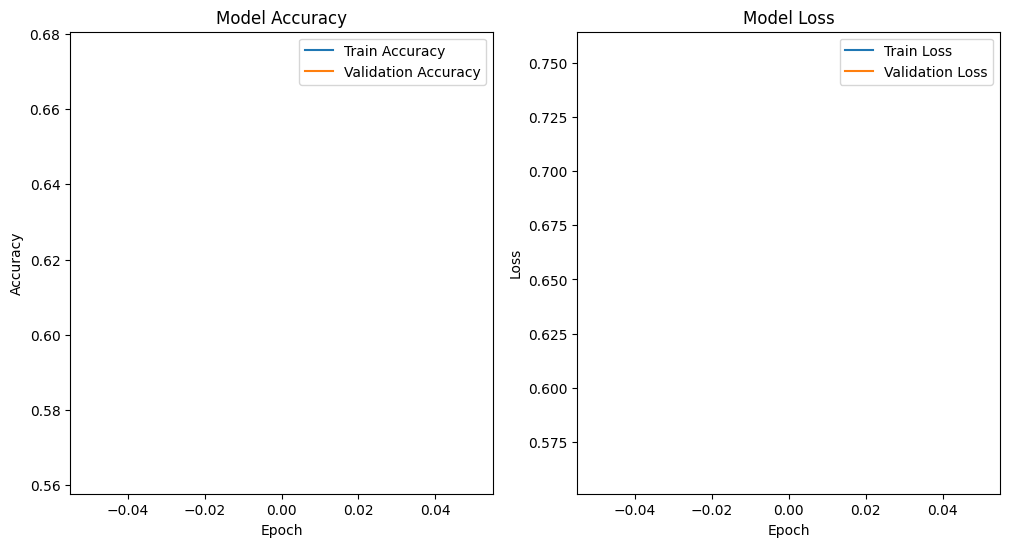

158/158 [==============================] - 979s 5s/step - loss: 0.7545 - accuracy: 0.5633 - val_loss: 0.5608 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 2/50
158/158 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6851
Epoch 2: val_loss improved from 0.56085 to 0.47035, saving model to /content/drive/My Drive/all files/03.7.2024-1.h5


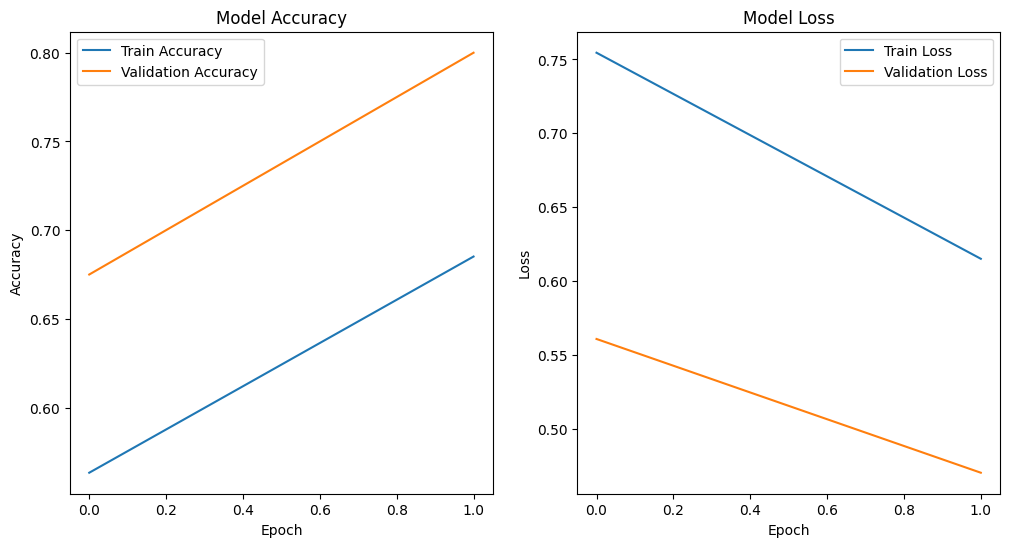

158/158 [==============================] - 122s 770ms/step - loss: 0.6151 - accuracy: 0.6851 - val_loss: 0.4703 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 3/50
158/158 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.7215
Epoch 3: val_loss improved from 0.47035 to 0.45895, saving model to /content/drive/My Drive/all files/03.7.2024-1.h5


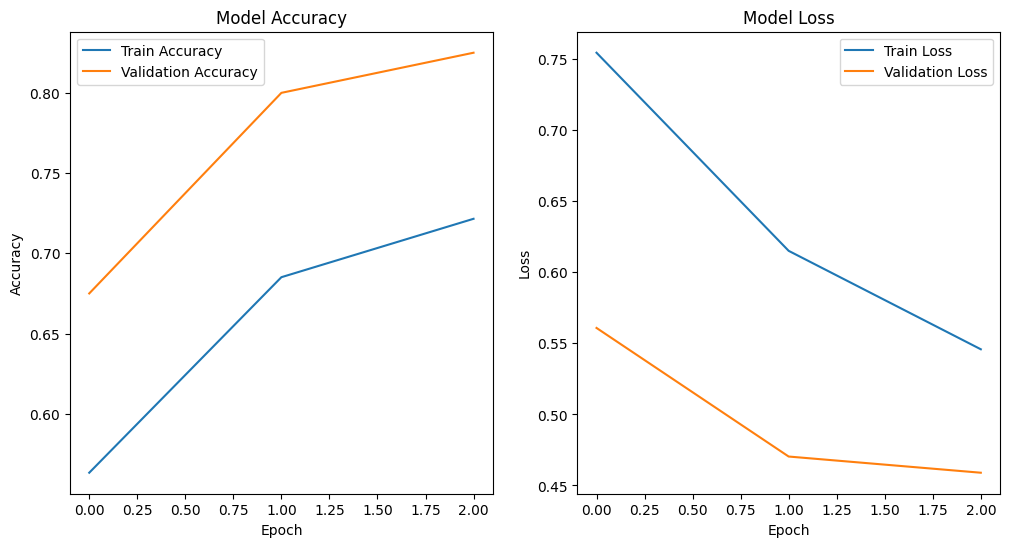

158/158 [==============================] - 114s 722ms/step - loss: 0.5458 - accuracy: 0.7215 - val_loss: 0.4590 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 4/50
158/158 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.7801
Epoch 4: val_loss did not improve from 0.45895


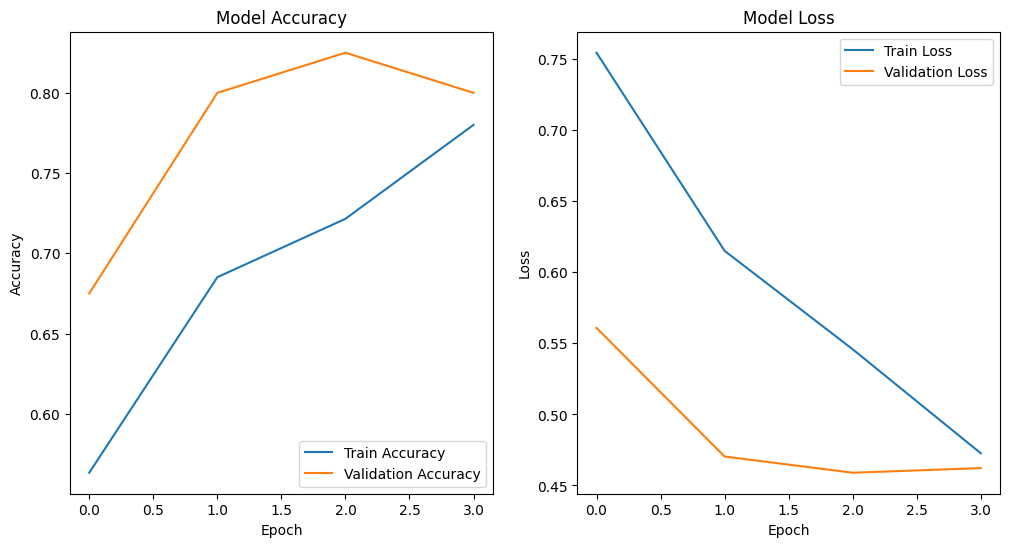

158/158 [==============================] - 109s 684ms/step - loss: 0.4726 - accuracy: 0.7801 - val_loss: 0.4622 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 5/50
158/158 [==============================] - ETA: 0s - loss: 0.4175 - accuracy: 0.8180
Epoch 5: val_loss improved from 0.45895 to 0.43445, saving model to /content/drive/My Drive/all files/03.7.2024-1.h5


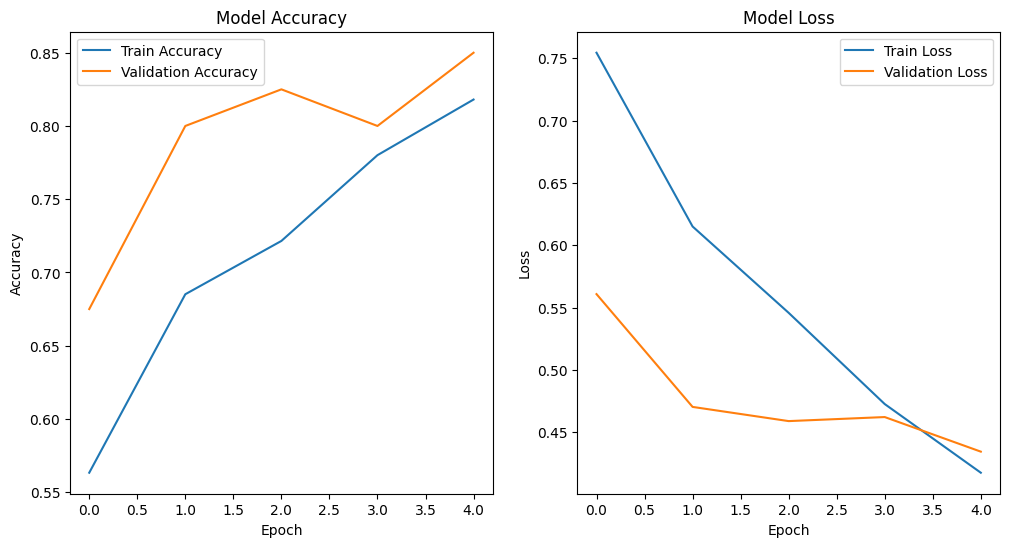

158/158 [==============================] - 108s 684ms/step - loss: 0.4175 - accuracy: 0.8180 - val_loss: 0.4344 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 6/50
158/158 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.8259
Epoch 6: val_loss did not improve from 0.43445


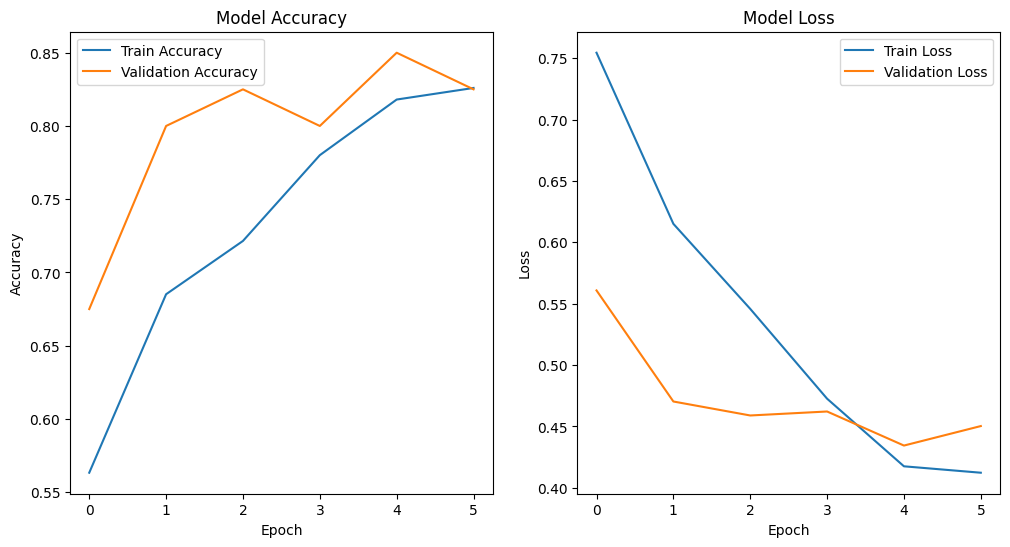

158/158 [==============================] - 108s 676ms/step - loss: 0.4123 - accuracy: 0.8259 - val_loss: 0.4503 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 7/50
158/158 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.8481
Epoch 7: val_loss improved from 0.43445 to 0.38532, saving model to /content/drive/My Drive/all files/03.7.2024-1.h5


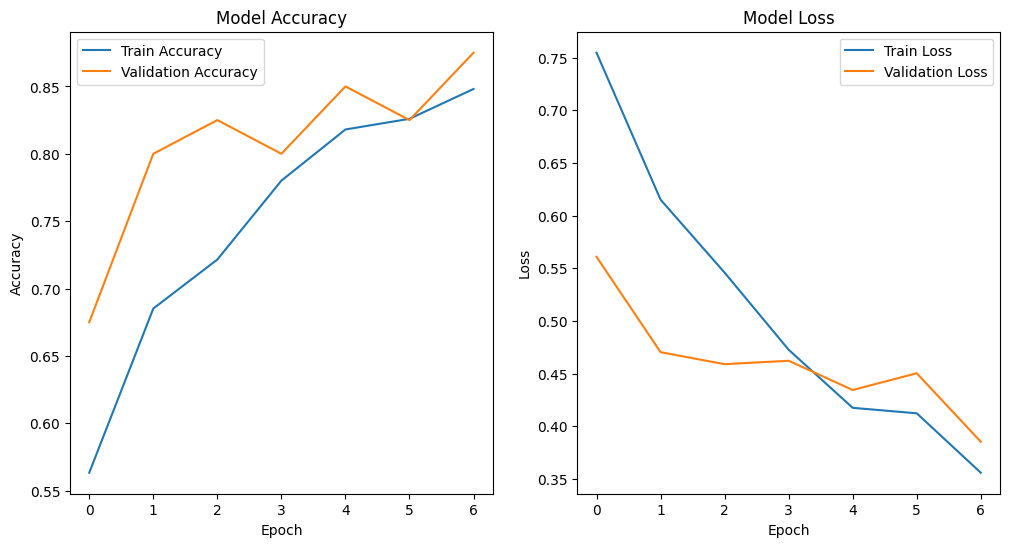

158/158 [==============================] - 107s 668ms/step - loss: 0.3559 - accuracy: 0.8481 - val_loss: 0.3853 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 8/50
158/158 [==============================] - ETA: 0s - loss: 0.3477 - accuracy: 0.8544
Epoch 8: val_loss did not improve from 0.38532


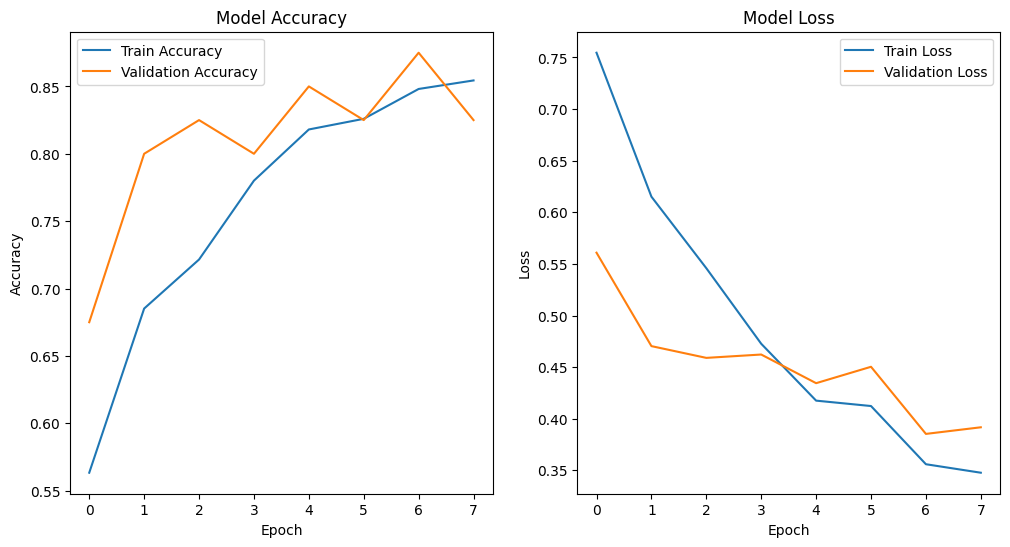

158/158 [==============================] - 113s 714ms/step - loss: 0.3477 - accuracy: 0.8544 - val_loss: 0.3917 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 9/50
158/158 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8718
Epoch 9: val_loss improved from 0.38532 to 0.37201, saving model to /content/drive/My Drive/all files/03.7.2024-1.h5


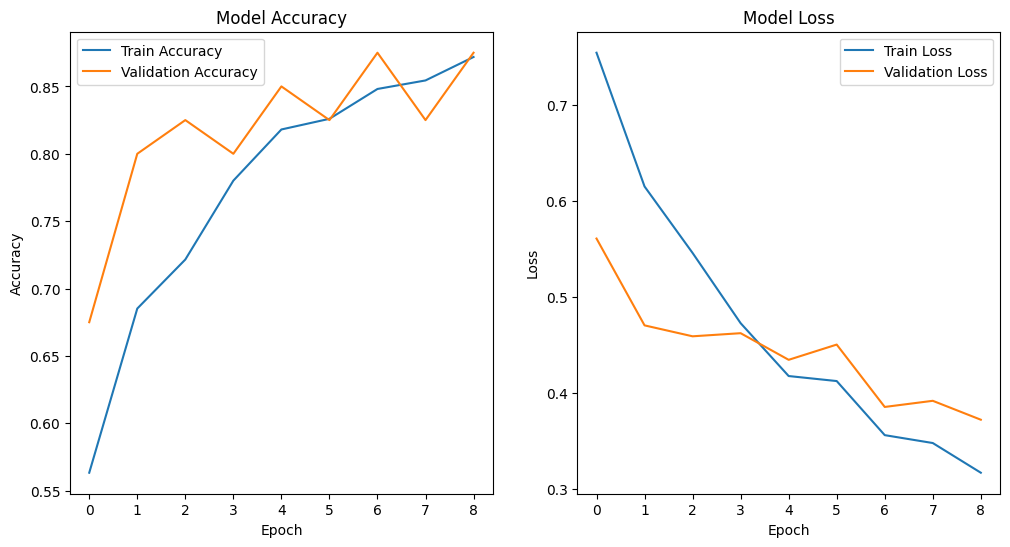

158/158 [==============================] - 112s 706ms/step - loss: 0.3168 - accuracy: 0.8718 - val_loss: 0.3720 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 10/50
158/158 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.8639
Epoch 10: val_loss did not improve from 0.37201


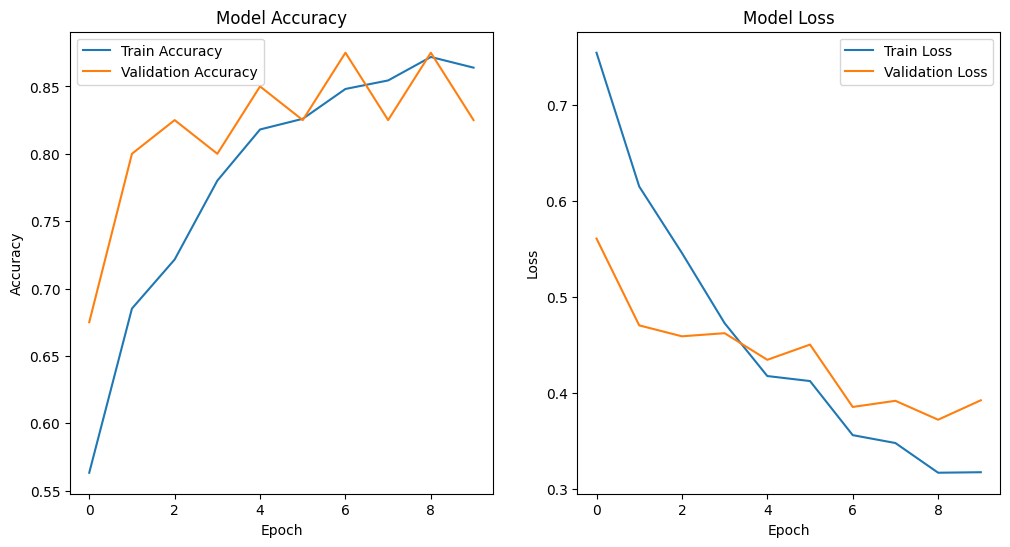

158/158 [==============================] - 107s 675ms/step - loss: 0.3173 - accuracy: 0.8639 - val_loss: 0.3923 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 11/50
158/158 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8797
Epoch 11: val_loss improved from 0.37201 to 0.34612, saving model to /content/drive/My Drive/all files/03.7.2024-1.h5


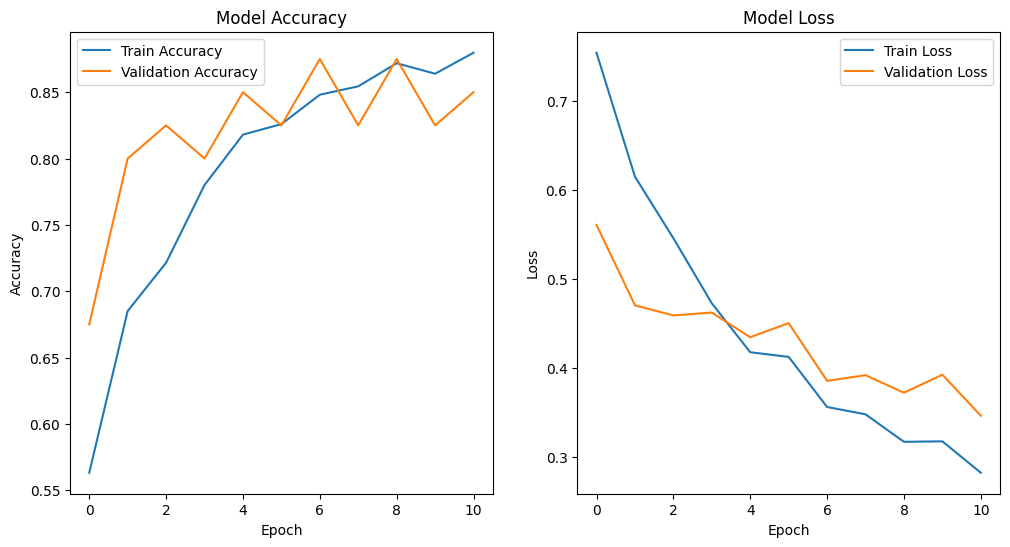

158/158 [==============================] - 105s 659ms/step - loss: 0.2820 - accuracy: 0.8797 - val_loss: 0.3461 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 12/50
158/158 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8718
Epoch 12: val_loss did not improve from 0.34612


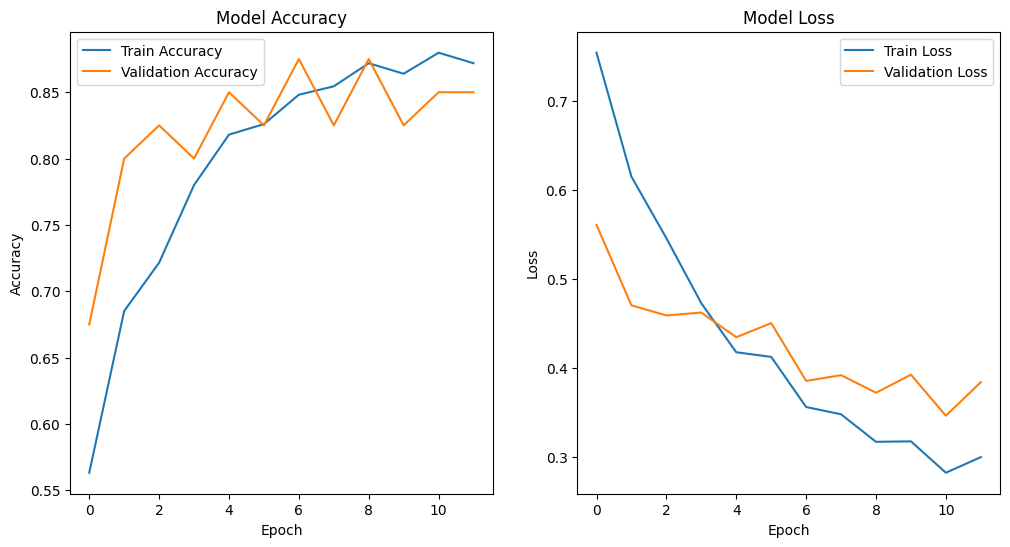

158/158 [==============================] - 107s 672ms/step - loss: 0.2995 - accuracy: 0.8718 - val_loss: 0.3838 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 13/50
158/158 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.8924
Epoch 13: val_loss did not improve from 0.34612


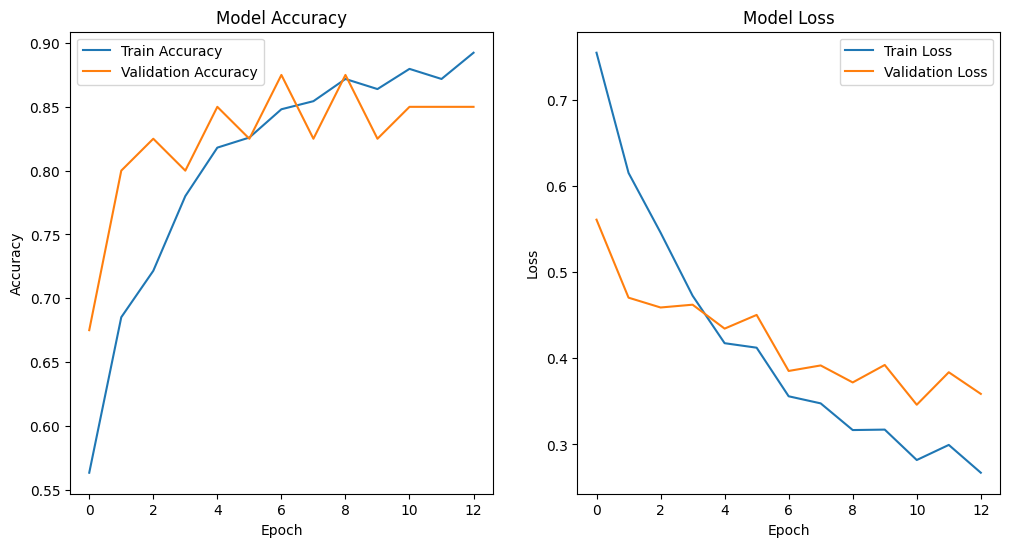

158/158 [==============================] - 113s 709ms/step - loss: 0.2673 - accuracy: 0.8924 - val_loss: 0.3587 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 14/50
158/158 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.9035
Epoch 14: val_loss did not improve from 0.34612


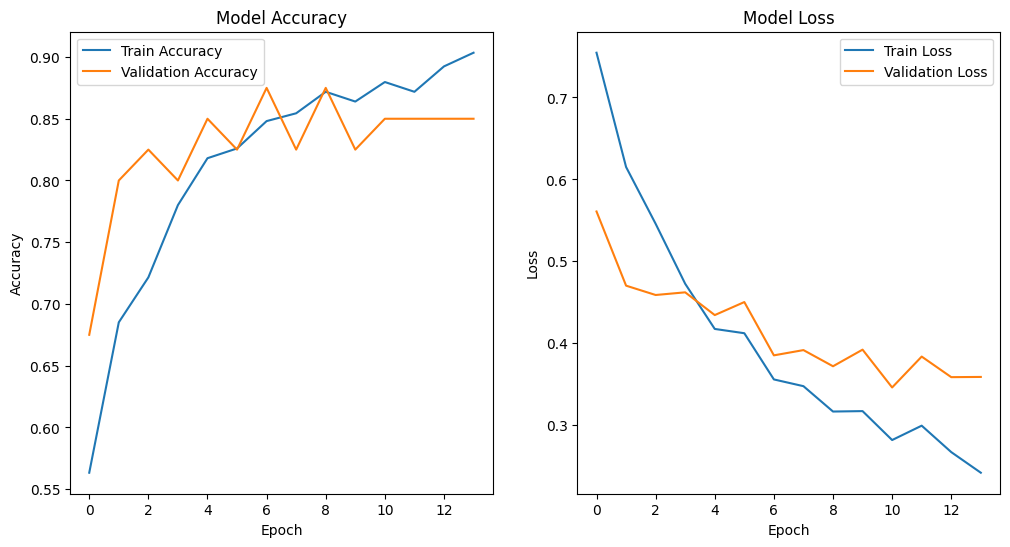

158/158 [==============================] - 108s 683ms/step - loss: 0.2421 - accuracy: 0.9035 - val_loss: 0.3590 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 15/50
158/158 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9161
Epoch 15: val_loss did not improve from 0.34612


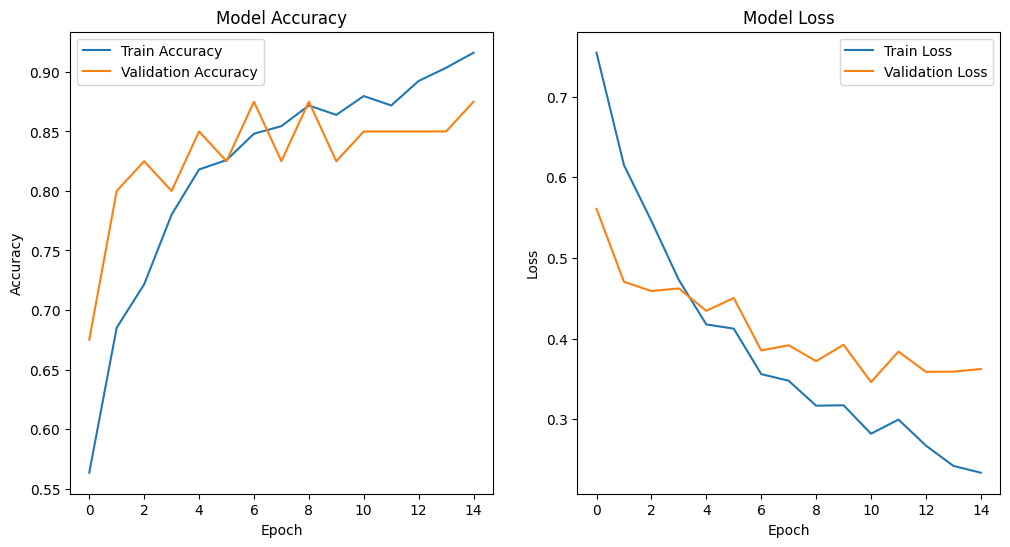

158/158 [==============================] - 108s 684ms/step - loss: 0.2336 - accuracy: 0.9161 - val_loss: 0.3622 - val_accuracy: 0.8750 - lr: 3.0000e-05
Epoch 16/50
158/158 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9082
Epoch 16: val_loss did not improve from 0.34612


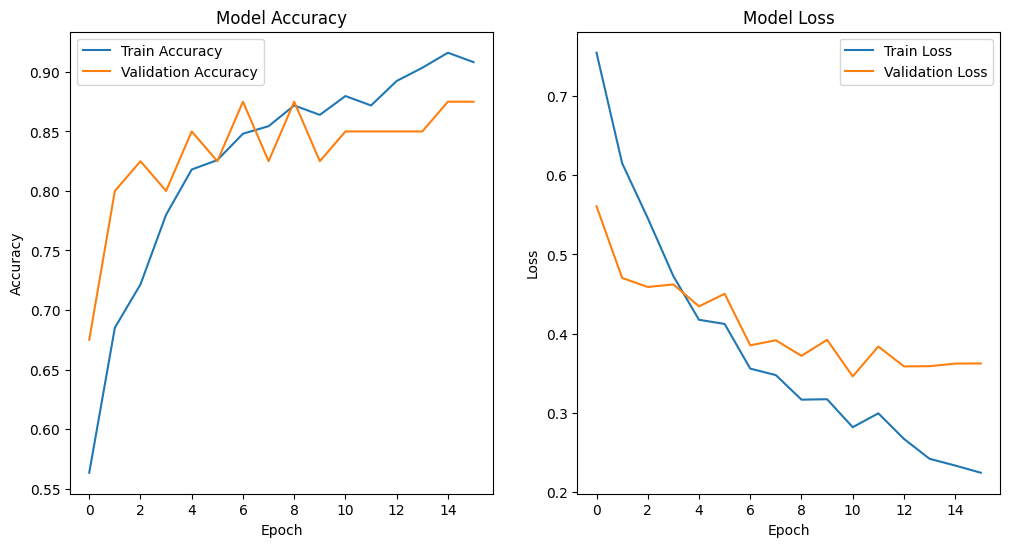

158/158 [==============================] - 107s 672ms/step - loss: 0.2246 - accuracy: 0.9082 - val_loss: 0.3625 - val_accuracy: 0.8750 - lr: 3.0000e-05
Epoch 17/50
158/158 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.9051
Epoch 17: val_loss did not improve from 0.34612


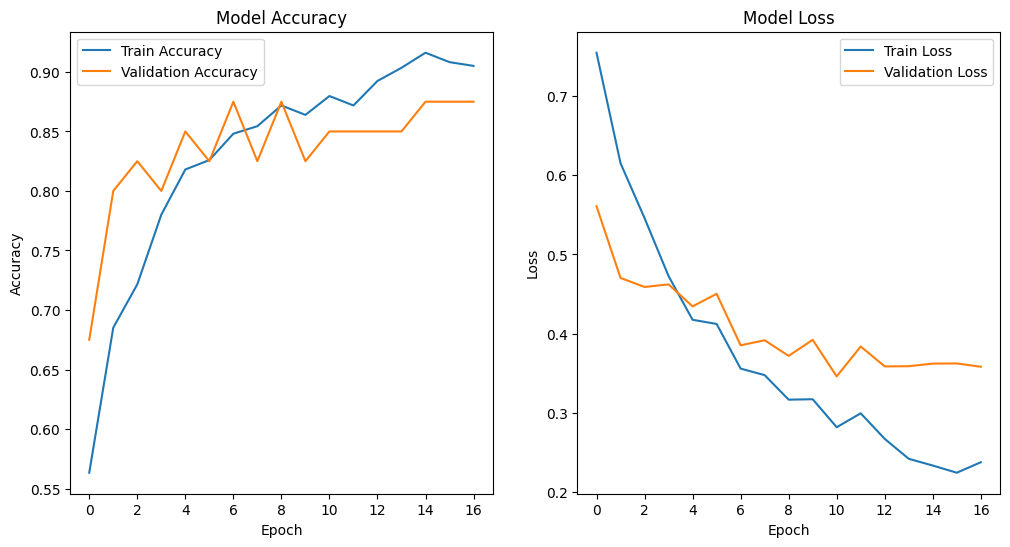

158/158 [==============================] - 108s 681ms/step - loss: 0.2378 - accuracy: 0.9051 - val_loss: 0.3583 - val_accuracy: 0.8750 - lr: 3.0000e-05
Epoch 18/50
158/158 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9098
Epoch 18: val_loss did not improve from 0.34612


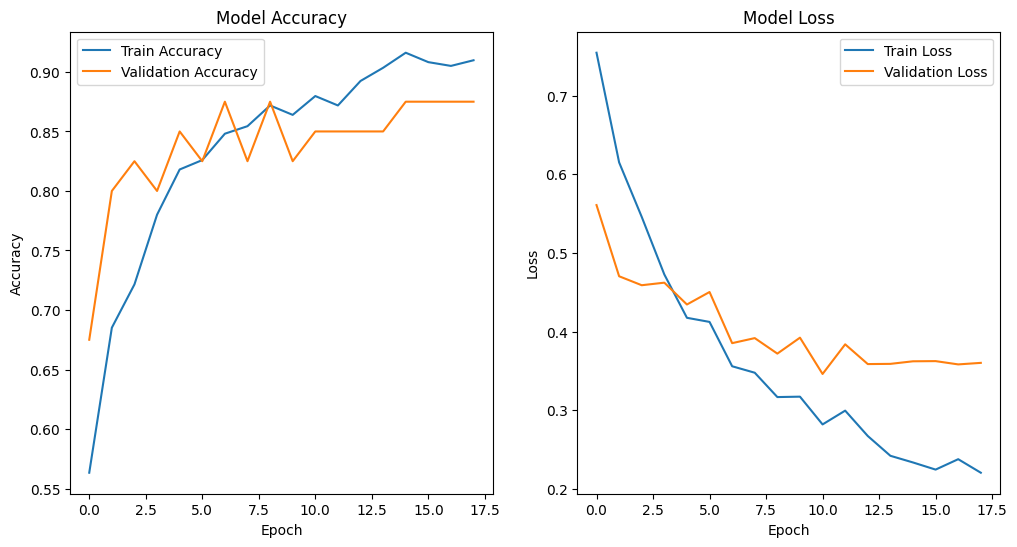

158/158 [==============================] - 107s 675ms/step - loss: 0.2206 - accuracy: 0.9098 - val_loss: 0.3602 - val_accuracy: 0.8750 - lr: 9.0000e-06
Epoch 18: early stopping


In [ ]:
#training

history = model.fit(train_ds_final,
                    epochs=50,
                    validation_data = val_ds,
                    callbacks=callbacks,
                    verbose=1)
  # Save the trained model
model.save('/content/drive/My Drive/all files/trained_model03.7.2024-1.h5')  # Update the path as needed

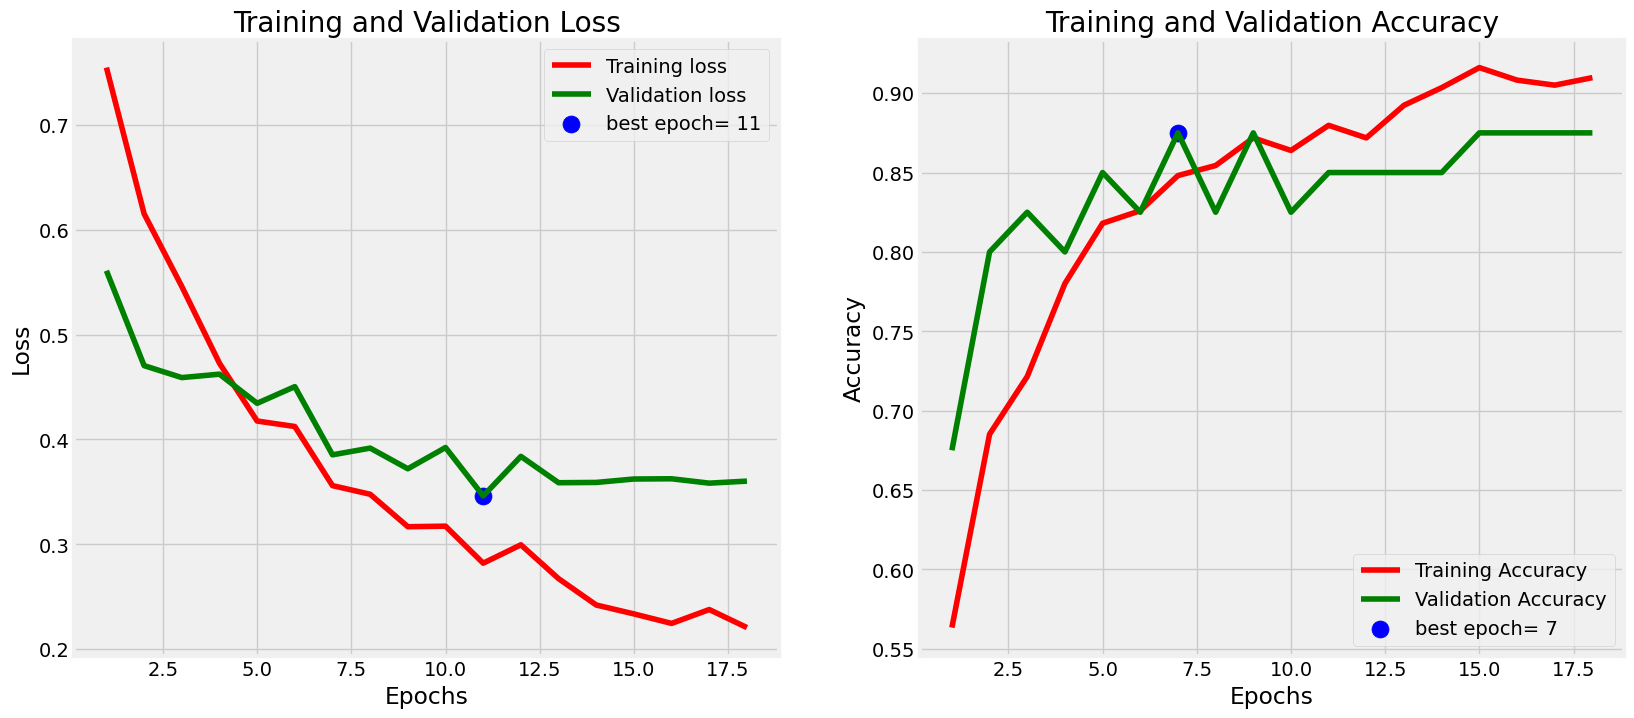

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaulation

In [ ]:
with keras.utils.CustomObjectScope({'KerasLayer': hub.KerasLayer}):
  old_model = tf.keras.models.load_model('/content/drive/My Drive/all files/trained_model03.7.2024-1.h5')
# Load the model from the specified path

# Print the model summary
old_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 224, 224, 3   0         
                             )]                                  
                                                                 
 keras_layer_1 (KerasLayer)  (None, 600)               12909544  
                                                                 
 dense_3 (Dense)             (None, 128)               76928     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                           

## Test frame extraction

In [ ]:
#test frame extraction and preprocessing
def new_extract_test_frames(video_path,label,resize=(224, 224), max_frames=50):
    video_path = video_path.decode("utf-8") if isinstance(video_path, bytes) else video_path
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = 7
    start_frame, end_frame = 0, total_frames
    frames = []
    empty_frame = np.zeros((resize[1], resize[0], 3))
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    while len(frames) < max_frames and cap.get(cv2.CAP_PROP_POS_FRAMES) <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if (cap.get(cv2.CAP_PROP_POS_FRAMES - 1 - start_frame) % interval) == 0:
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)

    cap.release()
    # Pad frames if fewer than max_frames were captured
    if len(frames) < max_frames:
      i = 0
      while len(frames) < max_frames:
        frames.append(frames[i])
        i+=1
    return np.array(frames,dtype=np.float32), int(label)

In [ ]:
def new_preprocess_test_dataset(file_paths, labels, max_frames=50, resize=(224, 224)):
    def load_and_preprocess(video_path, label):
        video_segments, segment_labels = tf.numpy_function(
            new_extract_test_frames,
            [video_path, label, resize, max_frames],
            [tf.float32, tf.int64])  # Ensure correct data types

        num_channels = 3  # RGB channels
        video_segments.set_shape([max_frames, resize[1], resize[0], num_channels])
        segment_labels.set_shape([])  # Single label per video

        return video_segments, segment_labels

    path_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = path_ds.map(lambda video_path, label: load_and_preprocess(video_path, label),
                          num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(1,drop_remainder=False).prefetch(tf.data.AUTOTUNE)


## Test loss and accuracy

In [ ]:
# Assuming test_file_paths and test_labels are already defined
test_ds = new_preprocess_test_dataset(test_file_paths, y_test)
loss, accuracy = old_model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

36/36 [==============================] - 11s 207ms/step - loss: 0.4857 - accuracy: 0.7778
Test Loss: 0.48567792773246765
Test Accuracy: 0.7777777910232544


## Test Confusion Matrix and ROC Curve

1/1 [==============================] - 0s 36ms/step


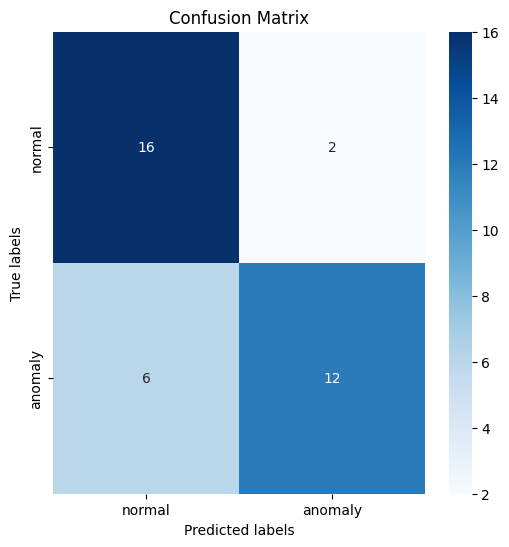

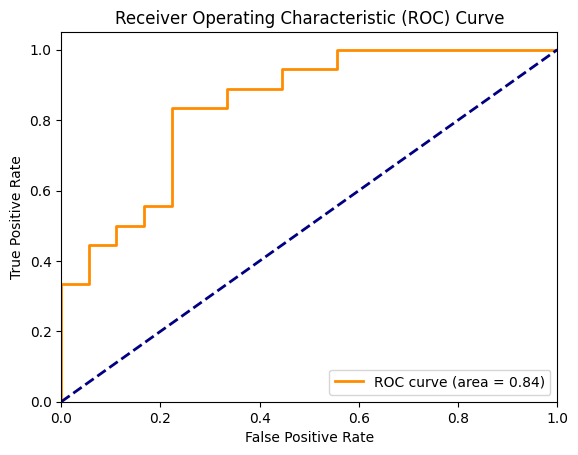

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Define which label number corresponds to normal
normal_label_index = 1  # Assume 1 is normal, adjust this based on your actual use case

y_pred = []
y_true = []
y_prob = []  # To store the predicted probabilities for the "anomaly" class

# Iterate through the test dataset
for img_batch, label_batch in test_ds.unbatch().batch(1):
    prob = old_model.predict(img_batch)[0]  # Get the prediction probability for the "anomaly" class

    # Append the probability of the "anomaly" class
    y_prob.append(prob)

    # Classify as 'anomaly' if the probability is greater than or equal to 0.5, else 'normal'
    if prob >= 0.5:
        y_pred.append('normal')
    else:
        y_pred.append('anomaly')

    # Determine the true label based on numeric index
    y_true.append('normal' if label_batch.numpy()[0] == normal_label_index else 'anomaly')

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['normal', 'anomaly'])

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(['normal', 'anomaly'])
ax.set_yticklabels(['normal', 'anomaly'])
plt.show()

# Convert labels to binary format for ROC computation
y_true_binary = [1 if label == 'normal' else 0 for label in y_true]

# Compute ROC curve and ROC area for the "anomaly" class
fpr, tpr, _ = roc_curve(y_true_binary, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
